In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [2]:
# looks weird, but makes pixel values between -1 and +1
# assume they are transformed from (0, 1)
# min value = (0 - 0.5) / 0.5 = -1
# max value = (1 - 0.5) / 0.5 = +1
transform = transforms.Compose([
    transforms.ToTensor(),transforms.Normalize(mean=(0.5,),std=(0.5,))
])

In [3]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transform,
    download=True)

100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 26656035.15it/s]


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 19179178.88it/s]

Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw


100%|██████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 11379313.21it/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



In [4]:
len(train_dataset)

60000

In [5]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [6]:
# Discriminator
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    # nn.Sigmoid()
)

In [7]:
# Generator
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)

In [8]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
D = D.to(device)
G = G.to(device)

In [9]:
# Loss and optimizers
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
# scale image back to (0, 1)
def scale_image(img):
    out = (img + 1) / 2
    return out

In [11]:
# Create a folder to store generated images
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [15]:
# Training loop

# labels to use in the loop
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)

# save losses
d_losses = []
g_losses = []

for epoch in range(10):
    for inputs, _ in data_loader:
        # don't need targets

        # reshape and move to GPU
        n = inputs.size(0)
        inputs = inputs.reshape(n, 784).to(device)

        # set ones and zeros to correct size
        ones = ones_[:n]
        zeros = zeros_[:n]


        ###########################
        ### Train discriminator ###
        ###########################

        # real images
        real_outputs = D(inputs)
        d_loss_real = criterion(real_outputs, ones)

        # fake images
        noise = torch.randn(n, latent_dim).to(device)
        fake_images = G(noise)
        fake_outputs = D(fake_images)
        d_loss_fake = criterion(fake_outputs, zeros)

        # gradient descent step
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

      #######################
      ### Train generator ###
      #######################

        # do it twice:
        for _ in range(2):
            # fake images
            noise = torch.randn(n, latent_dim).to(device)
            fake_images = G(noise)
            fake_outputs = D(fake_images)

            # reverse the labels!
            g_loss = criterion(fake_outputs, ones)

            # gradient descent step
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

        # save losses
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())


    ### print and save things ###
    print(f"Epoch: {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

    # PyTorch has a function to save a batch of images to file
    fake_images = fake_images.reshape(-1, 1, 28, 28)
    save_image(scale_image(fake_images), f"gan_images/{epoch+1}.png")


Epoch: 0, d_loss: 0.6762299537658691, g_loss: 0.7489501237869263
Epoch: 1, d_loss: 0.6890757083892822, g_loss: 0.6803697943687439
Epoch: 2, d_loss: 0.6743509769439697, g_loss: 0.7604056596755981
Epoch: 3, d_loss: 0.6937389373779297, g_loss: 0.6343770623207092
Epoch: 4, d_loss: 0.6816562414169312, g_loss: 0.7187035083770752
Epoch: 5, d_loss: 0.6700121164321899, g_loss: 0.7323430776596069
Epoch: 6, d_loss: 0.6750396490097046, g_loss: 0.7090327143669128
Epoch: 7, d_loss: 0.6930896043777466, g_loss: 0.747459888458252
Epoch: 8, d_loss: 0.6810272932052612, g_loss: 0.6906676292419434
Epoch: 9, d_loss: 0.6660407185554504, g_loss: 0.7759886980056763


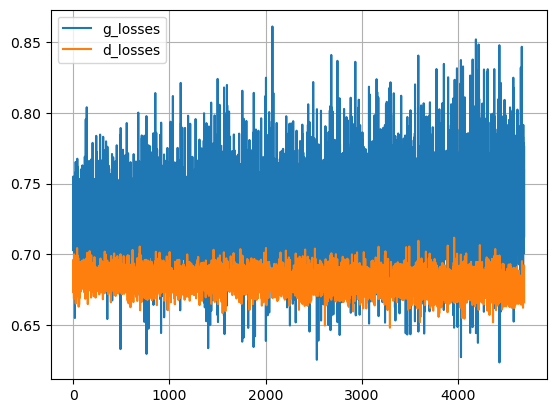

In [16]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.grid()
plt.legend()

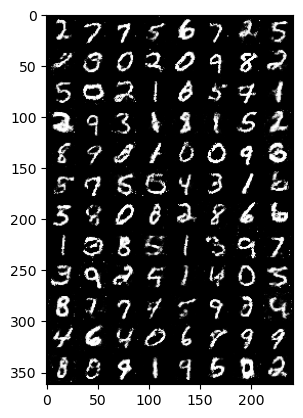

In [18]:
from skimage.io import imread
a = imread('gan_images/1.png')
plt.imshow(a)

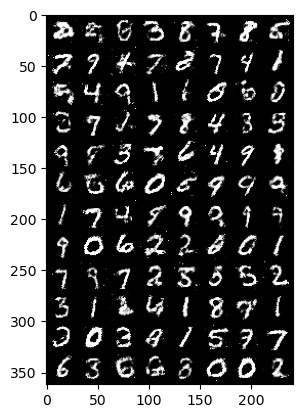

In [20]:
a = imread('gan_images/20.png')
plt.imshow(a)

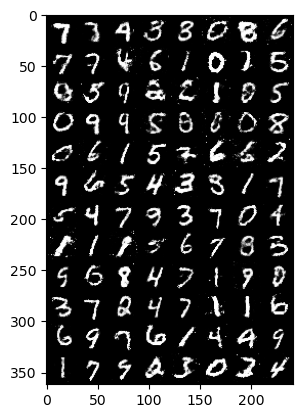

In [21]:
a = imread('gan_images/10.png')
plt.imshow(a)

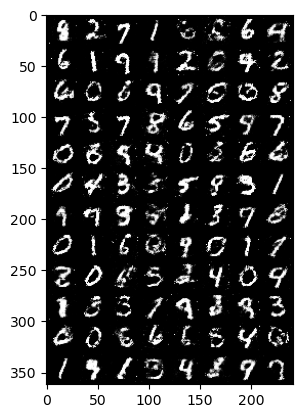

In [22]:
a = imread('gan_images/15.png')
plt.imshow(a)

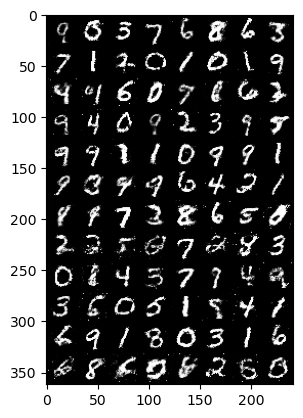

In [23]:
a = imread('gan_images/25.png')
plt.imshow(a)